# COVID-19 NYC Hospitalized Count Predictions

In this project, we have used the data from github: https://github.com/nychealth/coronavirus-data/blob/master/case-hosp-death.csv.



### Importing Libraries

In this assignment we have the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [Matplotlib](https://matplotlib.org/) - a comprehensive library for creating static, animated, and interactive visualizations in Python.
- [Seaborn](https://seaborn.pydata.org/) - a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
- [Sklearn](https://scikit-learn.org/stable/) - a tool for data mining and data analysis. 
- [Statsmodels](statsmodels.org/stable/index.html) - rovides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. 

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

### Loading Dataset

For this we have used *pandas* dataframe to load the data and converted *DATE_OF_INTEREST* to datetime object:

In [2]:
df = pd.read_csv('case-hosp-death.csv')
df['DATE_OF_INTEREST'] = pd.to_datetime(df.DATE_OF_INTEREST)
df.head()

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,2020-02-29,1,14,0
1,2020-03-01,1,4,0
2,2020-03-02,0,23,0
3,2020-03-03,2,22,0
4,2020-03-04,5,22,0


### Visualizing Dataset

The following cell will show the distribution of each feature in the dataset and its correlation.

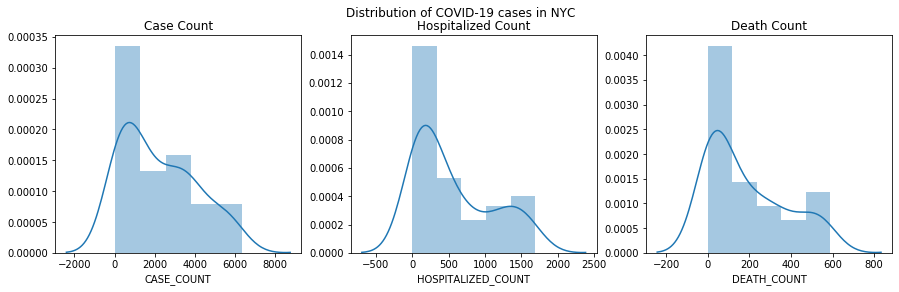

In [3]:
f,ax = plt.subplots(1,3,figsize=(15,4))
sns.distplot(df['CASE_COUNT'],ax=ax[0]).set_title('Case Count')
sns.distplot(df['HOSPITALIZED_COUNT'],ax=ax[1]).set_title('Hospitalized Count')
sns.distplot(df['DEATH_COUNT'],ax=ax[2]).set_title('Death Count')
f.suptitle('Distribution of COVID-19 cases in NYC')
plt.show()

## Data Transformation

**Log Transformation (Log Function + 1).** Many of my data points are 0 because many of the death cases were 0 in the start. For a quick fix, we added 1 to each data point. This works well since the log of 1 is 0. Furthermore, the same spread is retained since all points are increased by 1.

In [4]:
df['HOSPITALIZED_COUNT'] = np.log(df['HOSPITALIZED_COUNT'] + 1)
df['CASE_COUNT'] = np.log(df['CASE_COUNT'] + 1)
df['DEATH_COUNT'] = np.log(df['DEATH_COUNT'] + 1)
df.head()

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,2020-02-29,0.693147,2.708050,0.0
1,2020-03-01,0.693147,1.609438,0.0
2,2020-03-02,0.000000,3.178054,0.0
3,2020-03-03,1.098612,3.135494,0.0
4,2020-03-04,1.791759,3.135494,0.0


### Storing MinMax Values for Data Conversion

- This cell will store the max and min value for each feature in the dataset, to convert the log normalized values back to normal in *cell 20* and *cell 23*

In [5]:
upper_CC = df["CASE_COUNT"].max();
lower_CC = df["CASE_COUNT"].min();
upper_HC = df["HOSPITALIZED_COUNT"].max();
lower_HC = df["HOSPITALIZED_COUNT"].min();
upper_DC = df["DEATH_COUNT"].max();
lower_DC = df["DEATH_COUNT"].min();

**Normalization (Log Function + 1 Normalized).**  The log function plus normalization is an excellent way to transform skewed data if the results can still be skewed.

In [6]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [7]:
df['HOSPITALIZED_COUNT'] = normalize(df['HOSPITALIZED_COUNT'])
df['CASE_COUNT'] = normalize(df['CASE_COUNT'])
df['DEATH_COUNT'] = normalize(df['DEATH_COUNT'])
df.head()

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,2020-02-29,0.079144,0.364295,0.0
1,2020-03-01,0.079144,0.216507,0.0
2,2020-03-02,0.000000,0.427522,0.0
3,2020-03-03,0.125440,0.421796,0.0
4,2020-03-04,0.204583,0.421796,0.0


### Visualizing Transformed Data

The following cell will show the transformed data before applying modelling

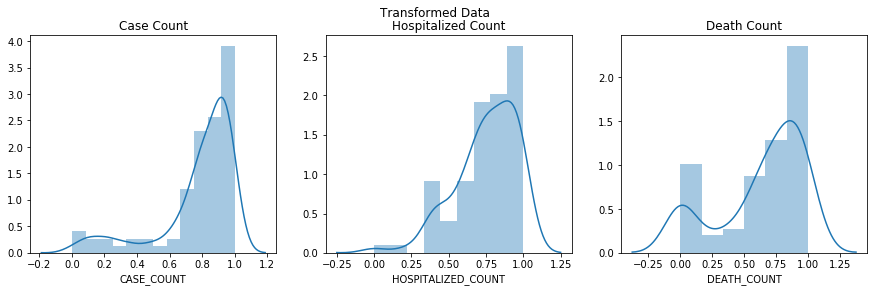

In [8]:
f,ax = plt.subplots(1,3,figsize=(15,4))
sns.distplot(df['CASE_COUNT'],ax=ax[0]).set_title('Case Count')
sns.distplot(df['HOSPITALIZED_COUNT'],ax=ax[1]).set_title('Hospitalized Count')
sns.distplot(df['DEATH_COUNT'],ax=ax[2]).set_title('Death Count')
f.suptitle('Transformed Data')
plt.show()

### *TRAINING* & *VALIDATION* Split

The following cell will show the split of data before April 7th used for data modelling and validation

In [9]:
train_df = df[df['DATE_OF_INTEREST'] < '2020-04-07'] 
train_df.head()

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,2020-02-29,0.079144,0.364295,0.0
1,2020-03-01,0.079144,0.216507,0.0
2,2020-03-02,0.000000,0.427522,0.0
3,2020-03-03,0.125440,0.421796,0.0
4,2020-03-04,0.204583,0.421796,0.0


### *TARGET* Split

The following cell will show the split of data from April 7th to April 17 used for predictions

In [10]:
actual_label_df_ols = df[(df['DATE_OF_INTEREST'] > '2020-04-06') & (df['DATE_OF_INTEREST'] < '2020-04-17')]
actual_label_df_glm = df[(df['DATE_OF_INTEREST'] > '2020-04-06') & (df['DATE_OF_INTEREST'] < '2020-04-17')]
actual_label_df_glm.head() #do not use in training 

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
38,2020-04-07,0.994296,0.989246,1.000000
39,2020-04-08,0.984676,0.984958,0.987303
40,2020-04-09,0.973313,0.973648,0.984401
41,2020-04-10,0.960362,0.965269,0.979341
42,2020-04-11,0.938452,0.938606,0.981146


### Split into train and val data for modelling

The following cell will show the split using *sklearn* randomly for the model training

In [11]:
X = train_df.drop(['DATE_OF_INTEREST','HOSPITALIZED_COUNT'],axis=1)
y = train_df['HOSPITALIZED_COUNT']
x_train, x_val,y_train,y_val = train_test_split(X,y,test_size =0.2, random_state=42)

## Linear Model

The following cell represents the Linear Model using *GLM* i.e. Generalized Linear Model from *statsmodels.formula*.
Allows for response variables that have error distribution models other than a normal distribution. 

- **GLM (Gamma Distribution).** : The gamma has a property shared by the lognormal; namely that when the shape parameter is held constant while the scale parameter is varied (as is usually done when using either for models), the variance is proportional to mean-squared (constant coefficient of variation).

In [12]:
glm_mod = smf.glm(formula = "HOSPITALIZED_COUNT ~ CASE_COUNT + DEATH_COUNT",data = train_df,
                  family = sm.families.Gamma()).fit();
glm_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     HOSPITALIZED_COUNT   No. Observations:                   38
Model:                            GLM   Df Residuals:                       35
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:                       0.0089016
Method:                          IRLS   Log-Likelihood:                 47.138
Date:                Mon, 08 Jun 2020   Deviance:                      0.37950
Time:                        16:02:46   Pearson chi2:                    0.312
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.8219      0.097     29.190      0.000       2.632       3.011
CASE_COUNT     -1.7576      0.159    -11.026      0.000      -2.070      -1.445
DEATH_COUNT    -0.1053      0.100     -1.052      0.293      -0.301       0.091
===============================================================================
"""

## Linear Model

The following cell represents the Linear Model using *OLS* i.e. Ordinary Least Square from *statsmodels*.
- OLS is an estimator in which the values of m and c (from the above equation) are chosen in such a way as to minimize the sum of the squares of the differences between the observed dependent variable and predicted dependent variable.

In [13]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     HOSPITALIZED_COUNT   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              456.2
Date:                Mon, 08 Jun 2020   Prob (F-statistic):                    4.30e-22
Time:                        16:02:46   Log-Likelihood:                          18.043
No. Observations:                  30   AIC:                                     -32.09
Df Residuals:                      28   BIC:                                     -29.28
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

## Model Evaluation 

- 1  MAPE (Mean Absolute percentage error) - express forecasting errors as ratios, and they are, therefore, dimensionless and easy to interpret.
- 2  MSE (Mean Square Error) - mse is a network performance function. It measures the network’s performance according to the mean of squared errors.
- 3  MAE (Mean Absolute Error) - It is the difference between the measured value and “true” value. 
- 4 R2 (R-squared) - coefficient of determination

#### GLM Metrics

In [14]:
pred_glm = glm_mod.predict(x_val);
y_true, y_pred = np.array(y_val), np.array(pred_glm)
print("MAPE",np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
print("MSE",mean_squared_error(y_val, y_pred))
print("MAE",mean_absolute_error(y_val, y_pred))
print("R2",r2_score(y_val, y_pred))

MAPE 2.1452189354383124
MSE 0.0003412212281718427
MAE 0.016115020561549474
R2 0.9941072646884889


#### OLS Metrics

In [15]:
predictions = model.predict(x_val) 
y_true, y_pred = np.array(y_val), np.array(predictions)
print("MAPE",np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
print("MSE",mean_squared_error(y_val, predictions))
print("MAE",mean_absolute_error(y_val, predictions))
print("R2",r2_score(y_val, predictions))

MAPE 13.87611030633355
MSE 0.010806731856923208
MAE 0.06727465133463688
R2 0.8133726592671047


### Target Predictions 

The following cell will take the new values and predict the hospitalized cases count. 
It will also evaluate the model and show the metrics.

#### GLM predictions

In [16]:
def GenLM(df):
    x_test = df.drop(['HOSPITALIZED_COUNT','DATE_OF_INTEREST'],axis=1)
    y_test = df['HOSPITALIZED_COUNT']
    y_pred = glm_mod.predict(x_test)
    df['Predicted_hsp_GLM'] = y_pred
    #print(y_pred)
   # print(y_test)
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    print("MAPE",np.mean(np.abs((y_true - y_pred) / y_true)) * 100)  #MAPE
    print("MSE",mean_squared_error(y_test, y_pred))
    print("MAE",mean_absolute_error(y_test, y_pred))
    print("R2",r2_score(y_test, y_pred))

In [17]:
GenLM(actual_label_df_glm)

MAPE 2.2453334653668557
MSE 0.0006155735033764372
MAE 0.021437412628368336
R2 0.11726355271765454


#### OLS Predicitons

In [18]:
def OLMfunc(df):
    x_test = df.drop(['HOSPITALIZED_COUNT','DATE_OF_INTEREST'],axis=1)
    y_test = df['HOSPITALIZED_COUNT']
    y_pred = model.predict(x_test)
    df['Predicted_hospitalized_count'] = y_pred
    df.head()
    #print(y_pred)
   # print(y_test)
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    print("MAPE",np.mean(np.abs((y_true - y_pred) / y_true)) * 100)  #MAPE
    print("MSE",mean_squared_error(y_test, y_pred))
    print("MAE",mean_absolute_error(y_test, y_pred))
    print("R2",r2_score(y_test, y_pred))

In [19]:
OLMfunc(actual_label_df_ols)

MAPE 1.4714347263402958
MSE 0.0002791830557065176
MAE 0.01391283484453939
R2 0.5996496642821


### Log Normalized Values -> Actual Values

- The following cell will convert the actual and predicted values back to original values using inverse log and normalized function
- This chunk conversion is for GLM-Gaussian Distribution

In [20]:
actual_label_df_glm["CASE_COUNT"] = (actual_label_df_glm["CASE_COUNT"]+lower_CC)*(upper_CC-lower_CC);
actual_label_df_glm["CASE_COUNT"] = np.exp(actual_label_df_glm["CASE_COUNT"]);
actual_label_df_glm["CASE_COUNT"] = actual_label_df_glm["CASE_COUNT"] - 1;

actual_label_df_glm["HOSPITALIZED_COUNT"] = (actual_label_df_glm["HOSPITALIZED_COUNT"]+lower_HC)*(upper_HC-lower_HC);
actual_label_df_glm["HOSPITALIZED_COUNT"] = np.exp(actual_label_df_glm["HOSPITALIZED_COUNT"]);
actual_label_df_glm["HOSPITALIZED_COUNT"] = actual_label_df_glm["HOSPITALIZED_COUNT"] - 1;

actual_label_df_glm["DEATH_COUNT"] = (actual_label_df_glm["DEATH_COUNT"]+lower_DC)*(upper_DC-lower_DC);
actual_label_df_glm["DEATH_COUNT"] = np.exp(actual_label_df_glm["DEATH_COUNT"]);
actual_label_df_glm["DEATH_COUNT"] = actual_label_df_glm["DEATH_COUNT"] - 1;

actual_label_df_glm["Predicted_hsp_GLM"] = (actual_label_df_glm["Predicted_hsp_GLM"]+lower_HC)*(upper_HC-lower_HC);
actual_label_df_glm["Predicted_hsp_GLM"] = np.exp(actual_label_df_glm["Predicted_hsp_GLM"]);
actual_label_df_glm["Predicted_hsp_GLM"] = actual_label_df_glm["Predicted_hsp_GLM"] - 1;
actual_label_df_glm["Predicted_hsp_GLM"] = round(actual_label_df_glm["Predicted_hsp_GLM"])

### Saving the predictions in the dataframe (GLM)

In [21]:
actual_label_df_glm

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,Predicted_hsp_GLM
38,2020-04-07,6051.0,1561.0,590.0,2145.0
39,2020-04-08,5562.0,1512.0,544.0,1862.0
40,2020-04-09,5035.0,1390.0,534.0,1600.0
41,2020-04-10,4495.0,1306.0,517.0,1354.0
42,2020-04-11,3710.0,1071.0,523.0,1045.0
43,2020-04-12,2870.0,967.0,555.0,763.0
44,2020-04-13,3297.0,1192.0,550.0,904.0
45,2020-04-14,4131.0,1057.0,503.0,1201.0
46,2020-04-15,3866.0,961.0,437.0,1082.0
47,2020-04-16,3515.0,850.0,398.0,947.0


### Visualizing the predictions (GLM)

The cell will plot a line graph for both actual and predicted values i.e. *hospitalized count* and *predicted hospitalized count*

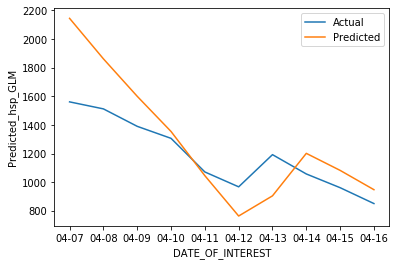

In [22]:
x = actual_label_df_glm['DATE_OF_INTEREST'].dt.strftime('%m-%d')
sns.lineplot(x = x,y='HOSPITALIZED_COUNT',data=actual_label_df_glm,markers=True,label='Actual')
sns.lineplot(x = x,y='Predicted_hsp_GLM',data=actual_label_df_glm,markers=True,label='Predicted')
plt.show()

### Log Normalized Values -> Actual Values

- The following cell will convert the actual and predicted values back to original values using inverse log and normalized function
- This chunk conversion is for OLS Algorithm to optimize the MAPE score

In [23]:
actual_label_df_ols["CASE_COUNT"] = (actual_label_df_ols["CASE_COUNT"]+lower_CC)*(upper_CC-lower_CC);
actual_label_df_ols["CASE_COUNT"] = np.exp(actual_label_df_ols["CASE_COUNT"]);
actual_label_df_ols["CASE_COUNT"] = actual_label_df_ols["CASE_COUNT"] - 1;

actual_label_df_ols["HOSPITALIZED_COUNT"] = (actual_label_df_ols["HOSPITALIZED_COUNT"]+lower_HC)*(upper_HC-lower_HC);
actual_label_df_ols["HOSPITALIZED_COUNT"] = np.exp(actual_label_df_ols["HOSPITALIZED_COUNT"]);
actual_label_df_ols["HOSPITALIZED_COUNT"] = actual_label_df_ols["HOSPITALIZED_COUNT"] - 1;

actual_label_df_ols["DEATH_COUNT"] = (actual_label_df_ols["DEATH_COUNT"]+lower_DC)*(upper_DC-lower_DC);
actual_label_df_ols["DEATH_COUNT"] = np.exp(actual_label_df_ols["DEATH_COUNT"]);
actual_label_df_ols["DEATH_COUNT"] = actual_label_df_ols["DEATH_COUNT"] - 1;

actual_label_df_ols["Predicted_hospitalized_count"] = (actual_label_df_ols["Predicted_hospitalized_count"]+lower_HC)*(upper_HC-lower_HC);
actual_label_df_ols["Predicted_hospitalized_count"] = np.exp(actual_label_df_ols["Predicted_hospitalized_count"]);
actual_label_df_ols["Predicted_hospitalized_count"] = actual_label_df_ols["Predicted_hospitalized_count"] - 1;
actual_label_df_ols["Predicted_hospitalized_count"] = round(actual_label_df_ols["Predicted_hospitalized_count"])


### Saving the predictions in the dataframe (OLS)

In [24]:
actual_label_df_ols

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,Predicted_hospitalized_count
38,2020-04-07,6051.0,1561.0,590.0,1504.0
39,2020-04-08,5562.0,1512.0,544.0,1401.0
40,2020-04-09,5035.0,1390.0,534.0,1289.0
41,2020-04-10,4495.0,1306.0,517.0,1173.0
42,2020-04-11,3710.0,1071.0,523.0,1000.0
43,2020-04-12,2870.0,967.0,555.0,809.0
44,2020-04-13,3297.0,1192.0,550.0,908.0
45,2020-04-14,4131.0,1057.0,503.0,1093.0
46,2020-04-15,3866.0,961.0,437.0,1032.0
47,2020-04-16,3515.0,850.0,398.0,953.0


### Visualizing the predictions (OLS)

The cell will plot a line graph for both actual and predicted values i.e. *hospitalized count* and *predicted hospitalized count*

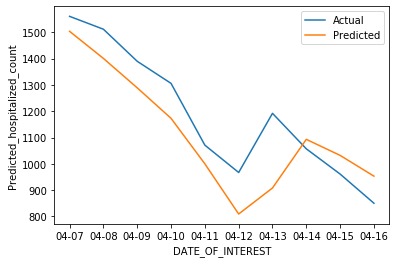

In [25]:
x = actual_label_df_ols['DATE_OF_INTEREST'].dt.strftime('%m-%d')
sns.lineplot(x = x,y='HOSPITALIZED_COUNT',data=actual_label_df_ols,markers=True,label='Actual')
sns.lineplot(x = x,y='Predicted_hospitalized_count',data=actual_label_df_ols,markers=True,label='Predicted')
plt.show()

### Saving Prediction Results -> Excel Sheets

In [26]:
actual_label_df_glm[['DATE_OF_INTEREST','Predicted_hsp_GLM']].to_excel('Predictions-GLM.xlsx')
actual_label_df_ols[['DATE_OF_INTEREST','Predicted_hospitalized_count']].to_excel('Predictions-OLS.xlsx')